# Downloading the dataset

In [1]:
import requests

url = "https://data.sba.gov/dataset/0ff8e8e9-b967-4f4e-987c-6ac78c575087/resource/3f838176-6060-44db-9c91-b4acafbcb28c/download/foia-7a-fy2010-fy2019-asof-250930.csv"
response = requests.get(url)
with open("data.csv", "wb") as f:
    f.write(response.content)


# Exploratory Data Analysis

## Data quality

### Data Properties

In [2]:
import pandas as pd

pd.set_option('display.max_columns', None)
df = pd.read_csv("data.csv")

# Trimming the dataset for Approval FY 2014-2019
df = df[df["ApprovalFY"]>=2014]

# Dataset properties
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns\n')
print(f"Number of duplicate rows: {df.duplicated().sum()}\n")
print(df.head(),'\n')
print("Column Properties:")
print("Column Name - Number of unique values - Data type")
for col in (df.columns):
    print(col, end =' - ')
    print(len(df[col].unique()), end=' - ')
    print(df[col].dtypes)

/var/folders/lc/vr9hmgmn2670c0pqbv8k0t700000gn/T/ipykernel_14377/1400559787.py:4: DtypeWarning: Columns (14,34) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data.csv")


The dataset has 354270 rows and 43 columns

Number of duplicate rows: 424

          AsOfDate Program                    BorrName  \
191481  2025-09-30      7A              AnthonyMaraffa   
191482  2025-09-30      7A      F.A.M. Development LLC   
191483  2025-09-30      7A   Pictures From The Sky LLC   
191484  2025-09-30      7A  GITIBIN AND ASSOCIATES INC   
191485  2025-09-30      7A               Bella Mod LLC   

                       BorrStreet       BorrCity BorrState  BorrZip  \
191481             60 Marion Road   Mattapoisett        MA     2739   
191482        430 WESTCHESTER CIR     VALPARAISO        IN    46385   
191483           222 Derby Street          Salem        MA     1970   
191484          4320 Campus Drive  NEWPORT BEACH        CA    92660   
191485  3018 Silver Cherry Circle        SUFFOLK        VA    23435   

        LocationID                 BankName  BankFDICNumber  BankNCUANumber  \
191481     32987.0             Eastern Bank         32773.0           

In [3]:
# Dropping 'AsOfDate' and 'Program' since they have only one value
df = df.drop(columns=['AsOfDate', 'Program'])
df.reset_index(drop='True')
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns\n')

# Analyzing categorical columns
cols = ['BusinessType', 'CollateralInd',
        'RevolverStatus', 'LoanStatus', 'Subprogram', 'SoldSecondMarketInd']

for col in cols:
    print(df[col].unique())

The dataset has 354270 rows and 41 columns

['INDIVIDUAL' 'CORPORATION' 'PARTNERSHIP' '        ']
['N' 'Y' nan]
[0 1]
['PIF' 'EXEMPT' 'CANCLD' 'CHGOFF' 'COMMIT' nan]
['FA$TRK (Small Loan Express)' 'Patriot Express' 'Guaranty'
 'Lender Advantage Initiative' 'Gulf Opportunity'
 'Revolving Line of Credit Exports - Sec. 7(a) (14)'
 'International Trade - Sec, 7(a) (16)' 'Standard Asset Based'
 'Community Advantage Initiative' 'Rural Lender Advantage'
 'Contract Guaranty' 'Small General Contractors - Sec. 7(a) (9)'
 'Seasonal Line of Credit']
[nan 'Y' 'N']


### Correcting Datatypes

In [4]:
# Correcting dataypes of all Date columns
cols = ['ApprovalDate', 'FirstDisbursementDate',
        'PaidinFullDate', 'ChargeoffDate']

for col in cols:
    df[col] = pd.to_datetime(df[col])
    print(df[col].dtype)



datetime64[ns]
datetime64[ns]
datetime64[ns]
datetime64[ns]


### Correcting incorrect data

In [5]:
import numpy as np
# Correcting all state columns as they show more than 50 states
valid_states = [
    'AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DE', 'FL', 'GA',
    'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 'MD',
    'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 'NJ',
    'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 'SC',
    'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY'
]
cols = ['BorrState','BankState', 'ProjectState']
for col in cols:
    df[col] = df[col].str.upper().str.strip()
    df[col] = df[col].where(df[col].isin(valid_states), np.nan)
    print(col,' - ',len(df[col].unique()))

df.loc[df['BusinessType'] == '        ', 'BusinessType'] = np.random.choice(['INDIVIDUAL', 'CORPORATION', 'PARTNERSHIP'])
print(df['CollateralInd'].unique())

BorrState  -  51
BankState  -  51
ProjectState  -  51
['N' 'Y' nan]


### Handling Null Values

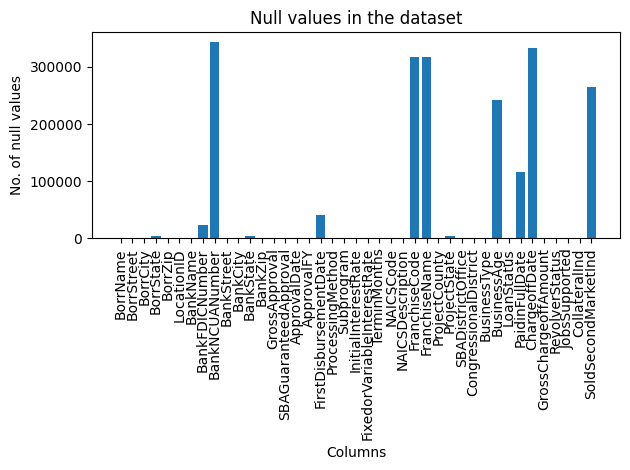

In [6]:
import matplotlib.pyplot as plt

# Null values in each column
nulls = df.isna().sum()
plt.figure(clear=True)
plt.bar(nulls.index, nulls)
plt.title("Null values in the dataset")
plt.tick_params(axis='x', labelrotation=90)
plt.xlabel("Columns")
plt.ylabel("No. of null values")
plt.tight_layout()
plt.show()

In [7]:
import numpy as np
# Dropping the columns which have more than 50% of null values
df = df.drop(columns=['BankNCUANumber', 'FranchiseCode', 'FranchiseName', 'BusinessAge'])
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns\n')

# Imputing Null values
df.fillna({'CollateralInd':'N'}, inplace=True)
print(df['BusinessType'].unique())

The dataset has 354270 rows and 37 columns

['INDIVIDUAL' 'CORPORATION' 'PARTNERSHIP']


### Handling Duplicate Rows

In [8]:
# dropping duplicate rows
print(f"Number of duplicate rows: {df.duplicated().sum()}")
df = df.drop_duplicates().reset_index(drop=True)
print(f'The dataset has {df.shape[0]} rows and {df.shape[1]} columns\n')

Number of duplicate rows: 433
The dataset has 353837 rows and 37 columns



## Data Distribution

### Gross Approval Amount

Min: 1000.0, Max: 5000000.0
Cummulative: 140.659508793


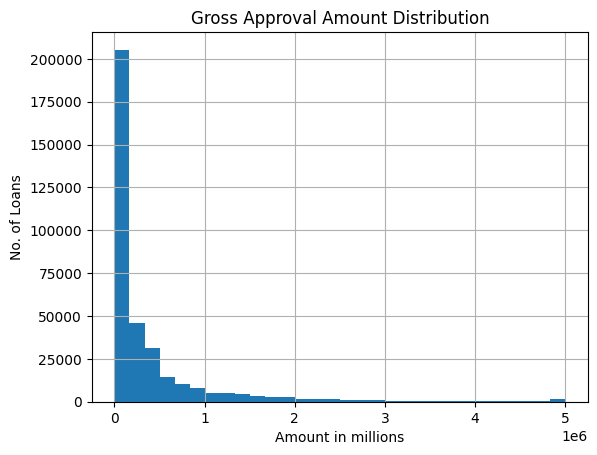

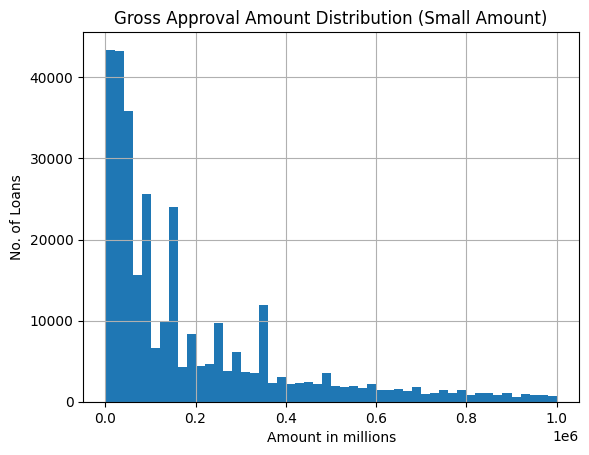

In [9]:
print(f'Min: {min(df['GrossApproval'])}, Max: {max(df['GrossApproval'])}')
print(f'Cummulative: {sum(df['GrossApproval'])/1000000000}')

# Distribution of Gross Approval Amount and SBA Guaranteed Approval Amount
df['GrossApproval'].hist(bins = 30)
plt.title("Gross Approval Amount Distribution")
plt.xlabel("Amount in millions")
plt.ylabel('No. of Loans')
plt.show()

df['GrossApproval'][df['GrossApproval'] < 1000000].hist(bins=50)
plt.title("Gross Approval Amount Distribution (Small Amount)")
plt.xlabel("Amount in millions")
plt.ylabel('No. of Loans')
plt.show()

# df['SBAGuaranteedApproval'].hist(bins=30)
# plt.title("SBA Guaranteed Approval Amount Distribution")
# plt.xlabel("Amount in millions")
# plt.ylabel('No. of Loans')
# plt.show()

# df['SBAGuaranteedApproval'][df['SBAGuaranteedApproval'] < 1000000].hist(bins=50)
# plt.title("SBA Guaranteed Approval Amount Distribution")
# plt.xlabel("Amount in millions")
# plt.ylabel('No. of Loans')
# plt.show()

### Loan Status

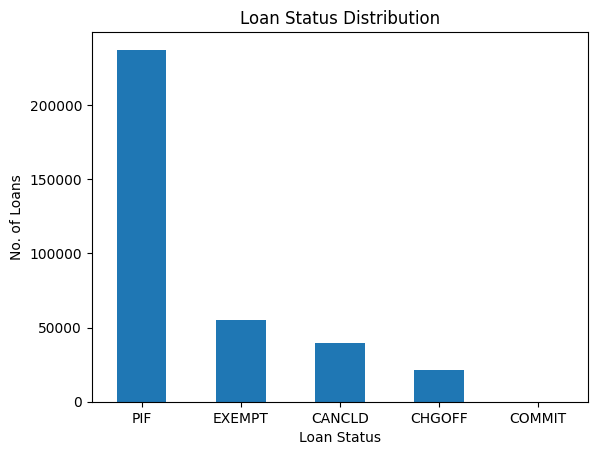

In [10]:
# Loan Status distribution
df['LoanStatus'].value_counts().plot.bar()
plt.title("Loan Status Distribution")
plt.xlabel('Loan Status')
plt.ylabel('No. of Loans')
plt.xticks(rotation = 0)
plt.show()


### Gross Defaulted Amount

Min: 11.0, Max: 4706180.93
Cummulative: 3.2808493137399997


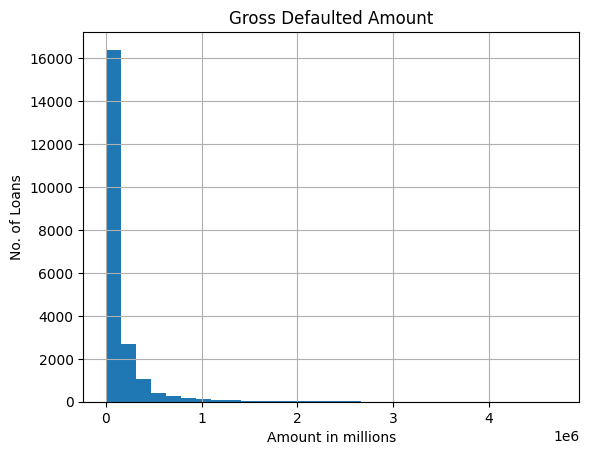

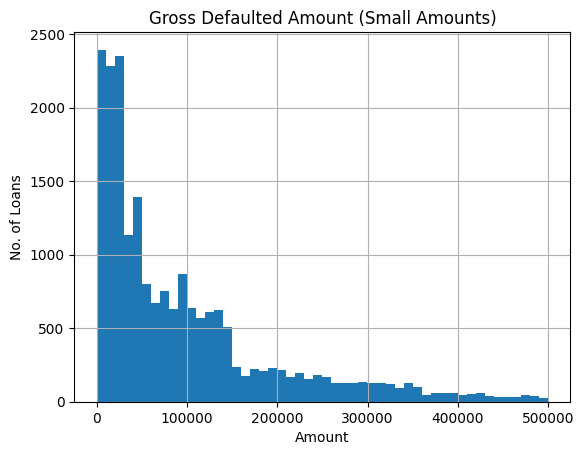

In [11]:
print(f'Min: {min(df['GrossChargeoffAmount'][df['GrossChargeoffAmount'] > 0])}, Max: {max(
    df['GrossChargeoffAmount'][df['GrossChargeoffAmount'] > 0])}')
print(f'Cummulative: {sum(df['GrossChargeoffAmount'])/1000000000}')
df['GrossChargeoffAmount'][df['GrossChargeoffAmount'] > 0].hist(bins=30)
plt.title("Gross Defaulted Amount")
plt.xlabel("Amount in millions")
plt.ylabel('No. of Loans')
plt.show()

df['GrossChargeoffAmount'][(df['GrossChargeoffAmount'] <= 500000) & (df['GrossChargeoffAmount'] > 0)].hist(bins=50)
plt.title("Gross Defaulted Amount (Small Amounts)")
plt.xlabel("Amount")
plt.ylabel('No. of Loans')
plt.show()

### Business Types

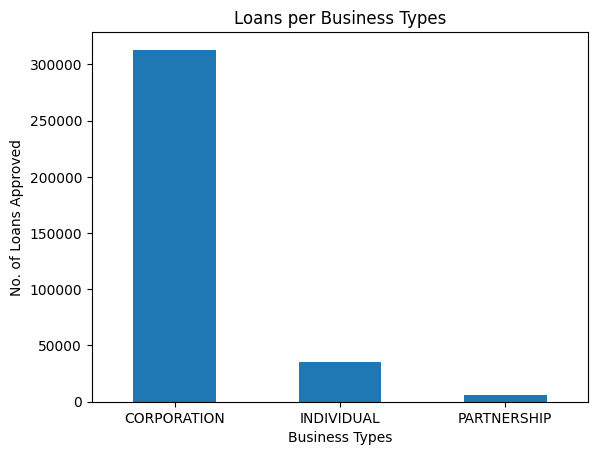

In [12]:
df['BusinessType'].value_counts().plot.bar()
plt.title("Loans per Business Types")
plt.xlabel('Business Types')
plt.ylabel('No. of Loans Approved')
plt.xticks(rotation=0)
plt.show()

### Interest Rate Types

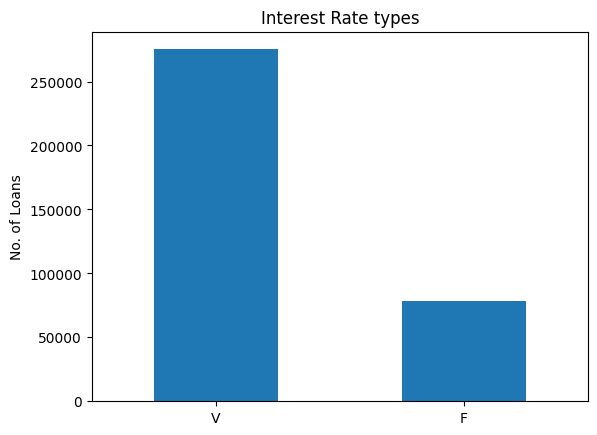

In [13]:
# Number of fixed and variable interest rates
df['FixedorVariableInterestRate'].value_counts().plot.bar()
plt.title('Interest Rate types')
plt.xlabel(None)
plt.ylabel('No. of Loans')
plt.xticks(rotation = 0)
plt.show()

### Demographic Distribution of Banks and Projects

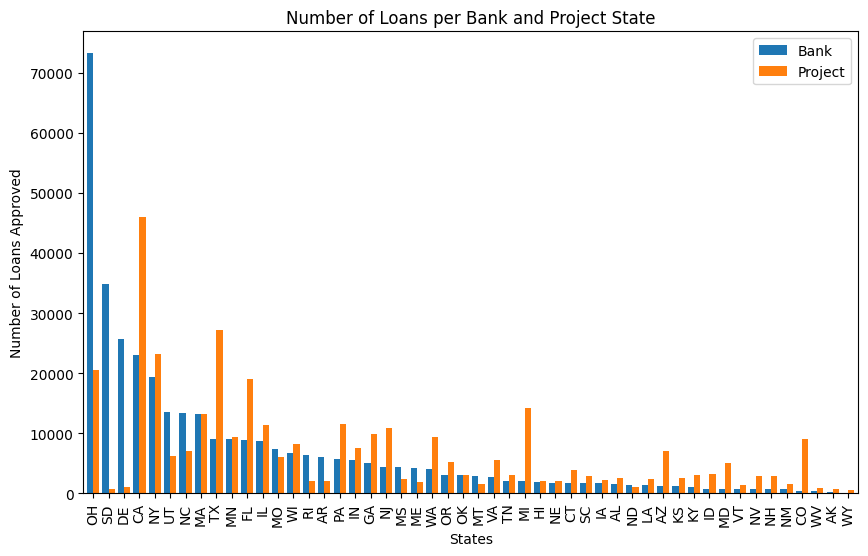

In [14]:
# Distribution of Banks
states = pd.DataFrame(df['BankState'].value_counts())
states.columns = ['Bank']
states['Project']= df['ProjectState'].value_counts()
states.sort_values(by='Bank', ascending= False, inplace=True)
states.plot.bar(figsize = (10,6), width= 0.8)
plt.title("Number of Loans per Bank and Project State")
plt.xlabel('States')
plt.ylabel('Number of Loans Approved')
plt.show()


## Relationships & Trends in data

### Trends over Time

   ApprovalFY  GrossApproval(Billions)  GrossChargeoffAmount(Millions)
0        2014                19.142368                      466.974929
1        2015                23.497555                      596.301679
2        2016                24.082475                      595.421974
3        2017                25.412957                      643.636321
4        2018                25.357318                      578.665304
5        2019                23.166836                      399.849107 




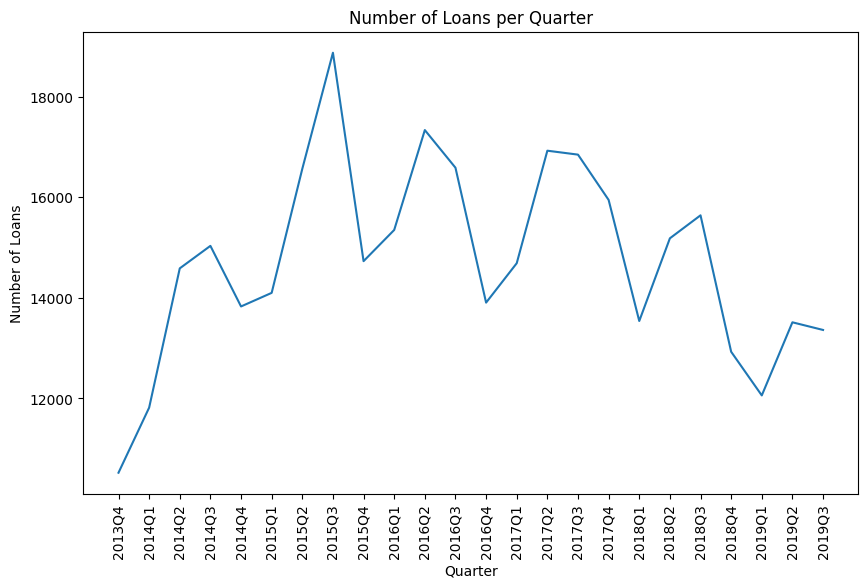

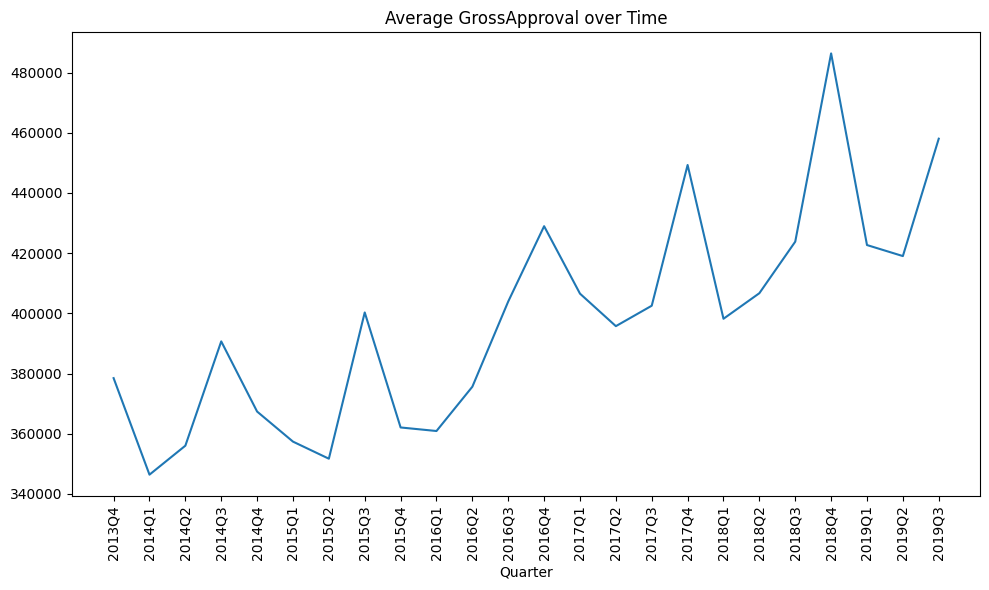

<Figure size 640x480 with 0 Axes>

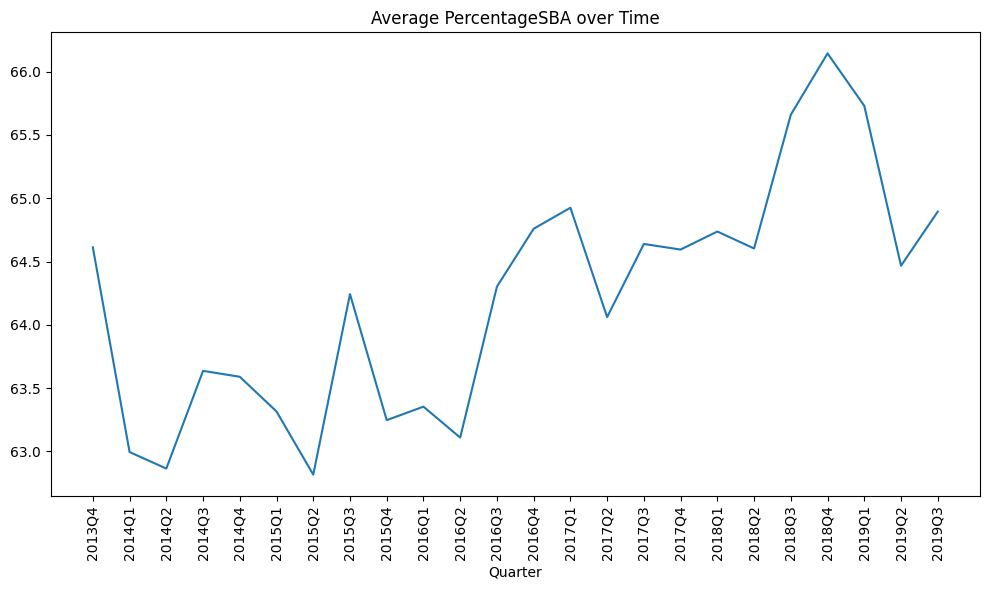

<Figure size 640x480 with 0 Axes>

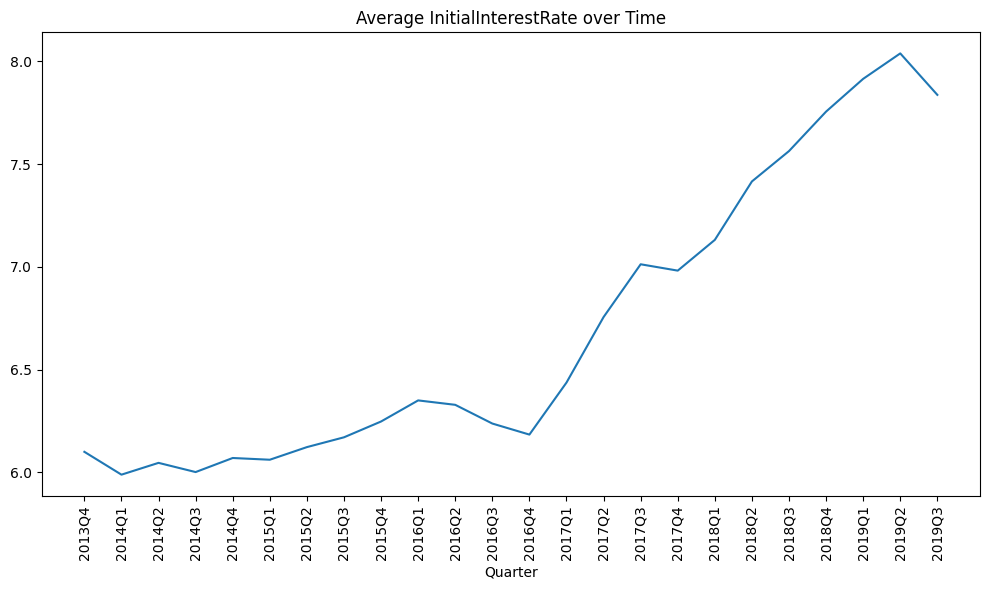

<Figure size 640x480 with 0 Axes>

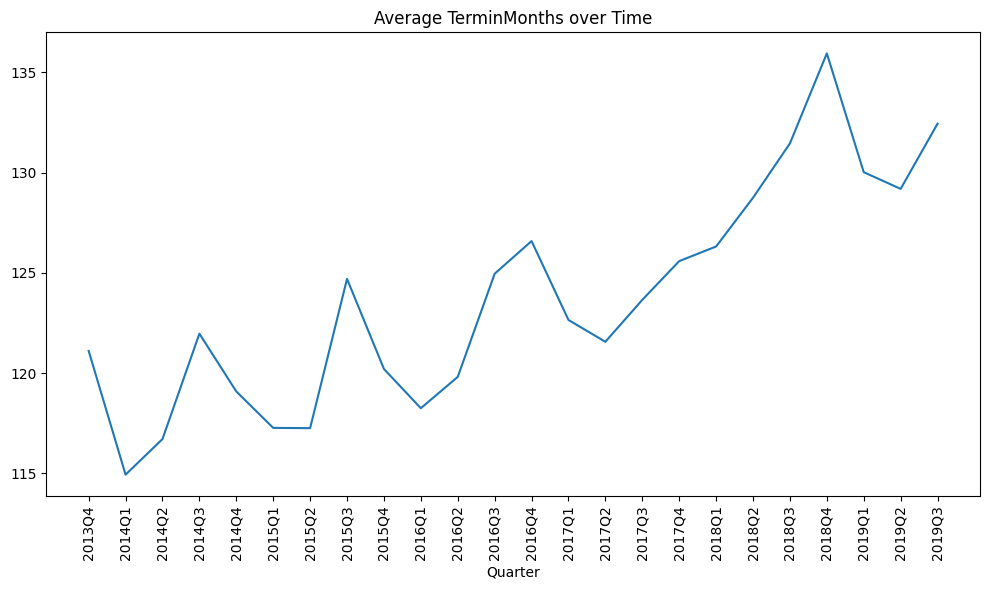

<Figure size 640x480 with 0 Axes>

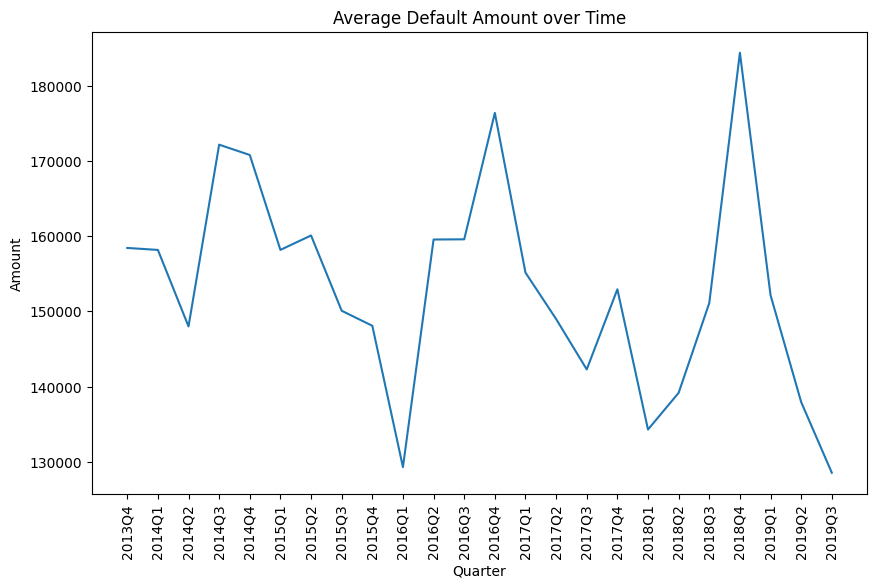

In [15]:
# Metrics per Year
Tot_per_yr = df.groupby('ApprovalFY')[
    ['GrossApproval', 'GrossChargeoffAmount']].sum().reset_index()
Tot_per_yr['GrossApproval(Billions)'] = Tot_per_yr['GrossApproval']/1000000000
Tot_per_yr['GrossChargeoffAmount(Millions)'] = Tot_per_yr['GrossChargeoffAmount']/1000000
Tot_per_yr = Tot_per_yr.drop(columns=['GrossApproval', 'GrossChargeoffAmount'])
print(Tot_per_yr,'\n\n')

# Number of Approvals over time
df['QuarterYear'] = df['ApprovalDate'].dt.to_period('Q').astype(str)
df['QuarterYear'].value_counts().sort_index().plot.line(figsize=(10,6))
plt.title('Number of Loans per Quarter')
plt.xlabel('Quarter')
plt.ylabel("Number of Loans")
plt.xticks(range(len(df['QuarterYear'].unique())), list(df['QuarterYear'].unique()),rotation = 90)
plt.show()

# Average of metrics over time
df['PercentageSBA'] = (df['SBAGuaranteedApproval'] / df['GrossApproval']) * 100
quarterly_avg = df.groupby('QuarterYear')[['GrossApproval', 'PercentageSBA', 'InitialInterestRate', 'TerminMonths']].mean().reset_index()
for col in quarterly_avg.columns[1:]:
    plt.figure(figsize=(10, 6))
    plt.plot(quarterly_avg['QuarterYear'], quarterly_avg[col])
    plt.title(f'Average {col} over Time')
    plt.xlabel('Quarter')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()
    plt.figure(clear=True)

chgoff_avg = df[df['GrossChargeoffAmount']>0].groupby('QuarterYear')[
    'GrossChargeoffAmount'].mean().reset_index()
plt.figure(figsize=(10, 6))
plt.plot(chgoff_avg['QuarterYear'], chgoff_avg['GrossChargeoffAmount'])
plt.title('Average Default Amount over Time')
plt.xlabel('Quarter')
plt.ylabel('Amount')
plt.xticks(rotation= 90)
plt.show()


### Trends over Demographics

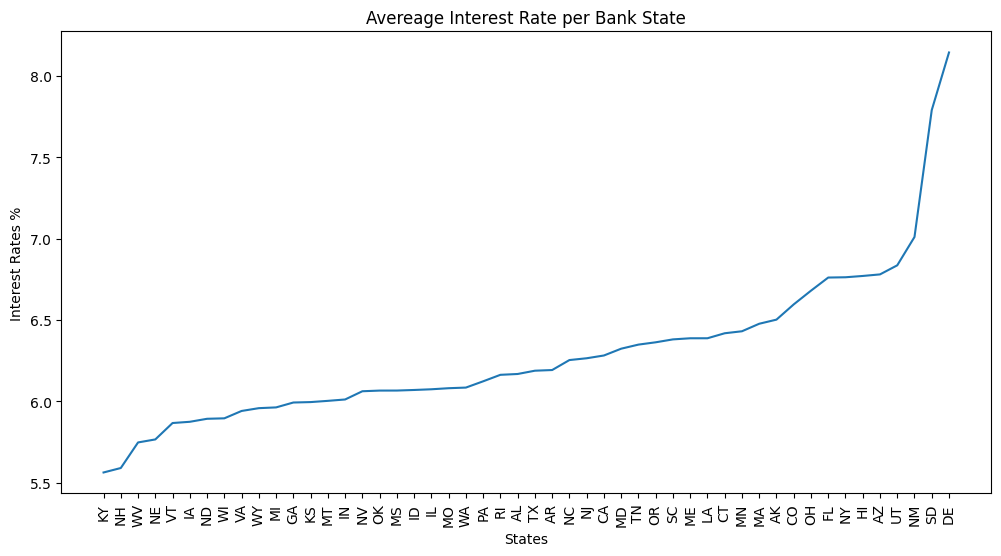

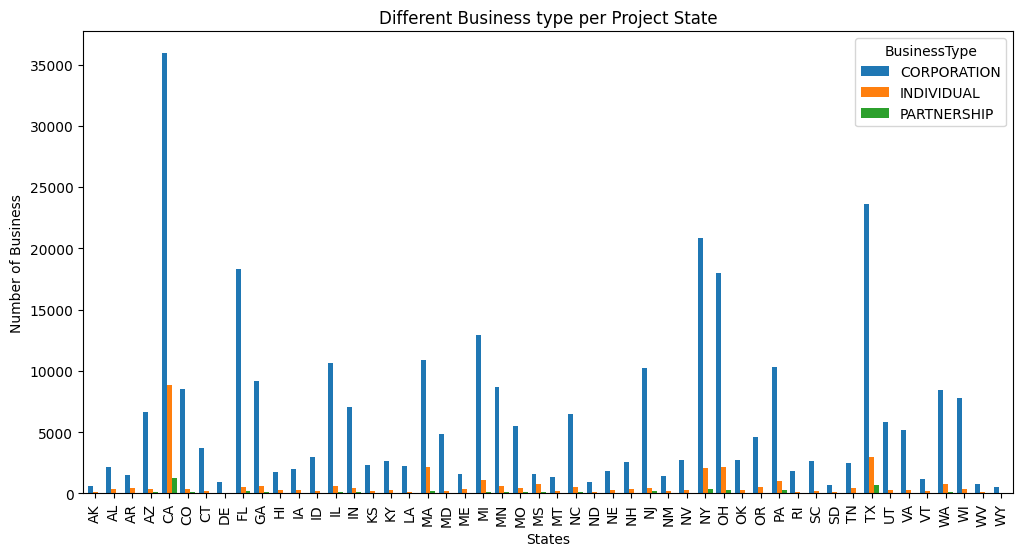

In [16]:
# Average Interest Rates per Bank State
avg_interest = df.groupby('BankState')['InitialInterestRate'].mean().sort_values()
avg_interest.plot.line(figsize=(12,6))
plt.title('Avereage Interest Rate per Bank State')
plt.xlabel("States")
plt.ylabel('Interest Rates %')
plt.xticks(range(50), list(avg_interest.index), rotation = 90)
plt.show()



# Different Business type per Project State
b_type_State = pd.crosstab(df['ProjectState'], df['BusinessType'])
b_type_State.plot(kind='bar', figsize=(12,6), width = 0.8)
plt.title('Different Business type per Project State')
plt.xlabel("States")
plt.ylabel('Number of Business')
plt.show()

### Trends over Business Types

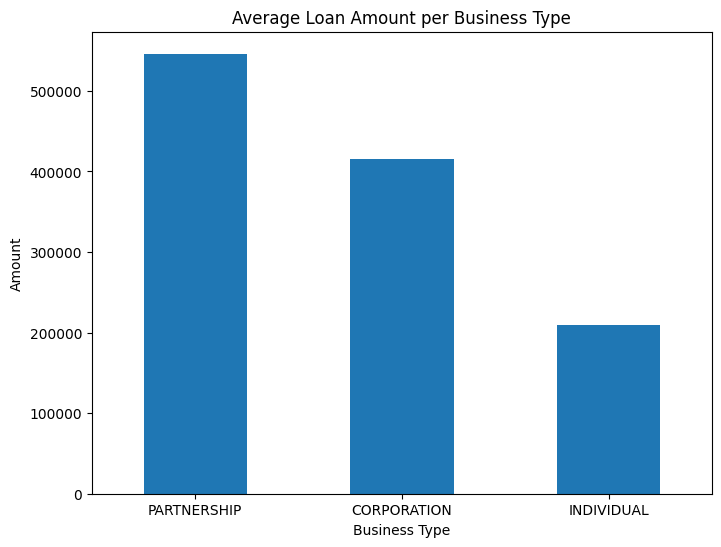

In [17]:
# Average Loan Amount per Business Type
avg_btype = df.groupby('BusinessType')[['GrossApproval', 'GrossChargeoffAmount']].mean()
avg_btype['GrossApproval'].sort_values(ascending=False).plot(kind='bar', figsize=(8,6))
plt.title("Average Loan Amount per Business Type")
plt.xlabel('Business Type')
plt.ylabel('Amount')
plt.xticks(rotation=0)
plt.show()


### Default Rate Trends

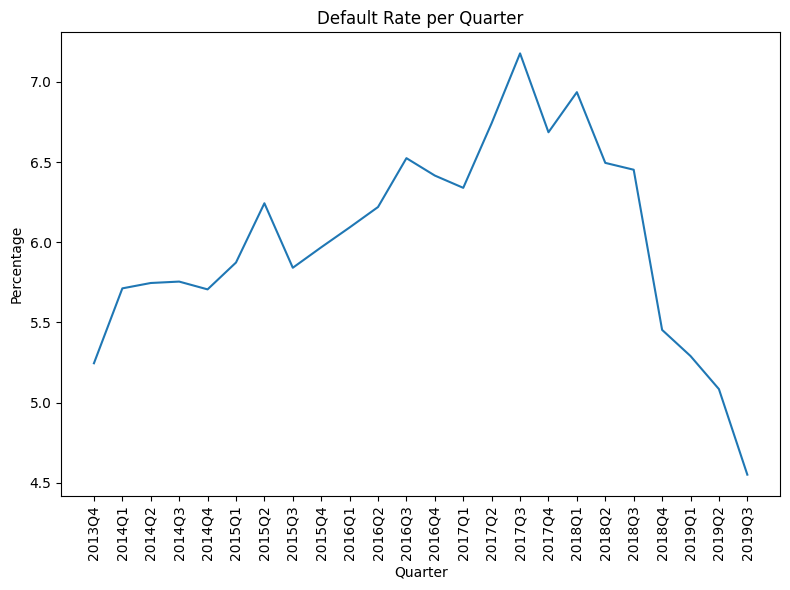

/var/folders/lc/vr9hmgmn2670c0pqbv8k0t700000gn/T/ipykernel_14377/2558564605.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_summary = bin_summary.groupby('GrossApproval')['is_defaulted'].mean().reset_index()


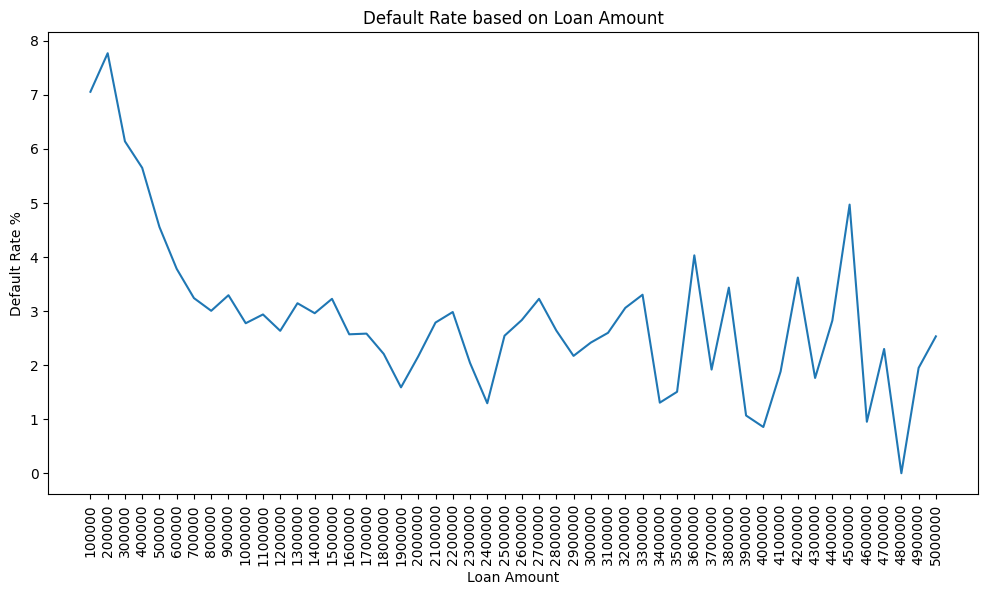

Index(['InitialInterestRate', 'isDefaulted'], dtype='object')


/var/folders/lc/vr9hmgmn2670c0pqbv8k0t700000gn/T/ipykernel_14377/2558564605.py:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  interest = interest.groupby('InitialInterestRate')['isDefaulted'].mean().reset_index()


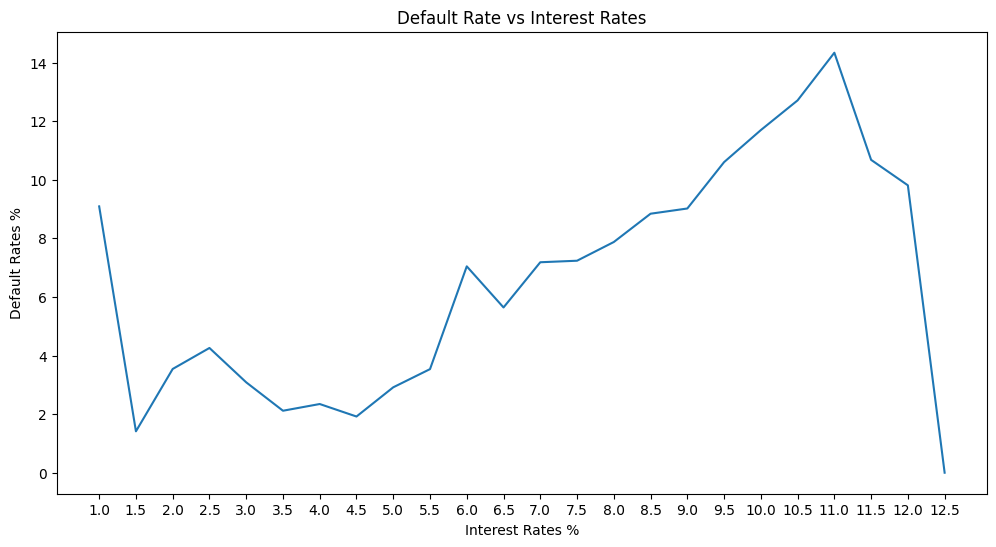

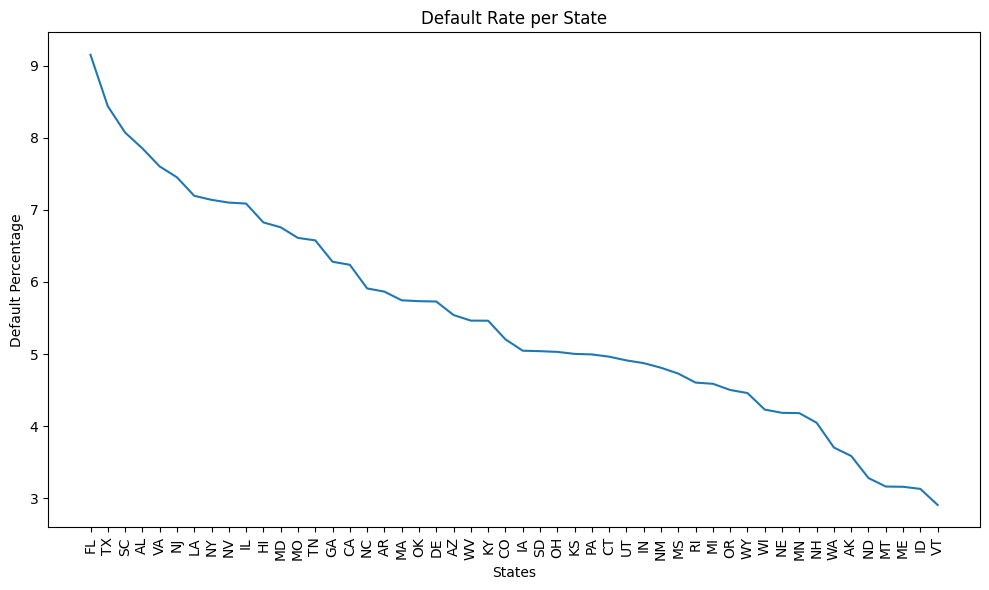

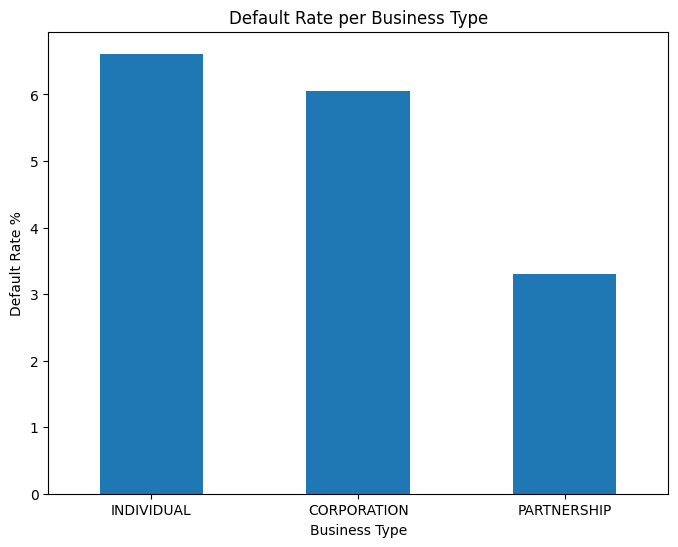

In [18]:
# Default Rate per Quarter
loan_sts = pd.crosstab(df['QuarterYear'], df['LoanStatus'])
loan_sts['TOTAL'] = loan_sts.sum(axis=1)
chgoff_rate = (loan_sts['CHGOFF']/loan_sts['TOTAL'])*100
chgoff_rate.plot(kind='line', figsize=(8, 6))
plt.title("Default Rate per Quarter")
plt.xlabel("Quarter")
plt.ylabel("Percentage")
plt.xticks(range(len(chgoff_rate)), list(chgoff_rate.index), rotation=90)
plt.tight_layout()
plt.show()

# Default Rate based on Loan Amount
df['is_defaulted'] = df['LoanStatus'].isin(['CHGOFF'])
bins = np.arange(0, max(df['GrossApproval'])+100000, 100000)
labels = [f'{int(i)+100000}' for i in bins[:-1]]
bin_summary = pd.DataFrame(pd.cut(df['GrossApproval'],bins=bins, labels= labels, right=False))
bin_summary['is_defaulted'] = df['is_defaulted']

bin_summary = bin_summary.groupby('GrossApproval')['is_defaulted'].mean().reset_index()
bin_summary['is_defaulted'] = bin_summary['is_defaulted']*100
bin_summary.plot(kind='line', x='GrossApproval', figsize=(12,6))
plt.title('Default Rate based on Loan Amount')
plt.xlabel("Loan Amount")
plt.ylabel("Default Rate %")
plt.xticks(range(0, len(bin_summary)), bin_summary['GrossApproval'], rotation=90)
plt.legend().remove()
plt.show()

# Default Rate based on interest
int_bins = np.arange(1, max(df['InitialInterestRate']),0.5)
interest = pd.DataFrame(pd.cut(df['InitialInterestRate'], bins = int_bins, labels=int_bins[:-1], right=False))
interest['isDefaulted'] = df['is_defaulted']
print(interest.columns)
interest = interest.groupby('InitialInterestRate')['isDefaulted'].mean().reset_index()
interest['isDefaulted'] *= 100
interest.plot(kind='line', x='InitialInterestRate', figsize=(12,6))
plt.title('Default Rate vs Interest Rates')
plt.xlabel('Interest Rates %')
plt.ylabel('Default Rates %')
plt.xticks(range(len(interest)), int_bins[:-1])
plt.legend().remove()
plt.show()

# Default Rate per Project State
loan_sts_bank = pd.crosstab(df['ProjectState'], df['LoanStatus'])
chgoff_rate = pd.DataFrame(
    (loan_sts_bank['CHGOFF']/loan_sts_bank.sum(axis=1))*100)
chgoff_rate.columns = ['ProjectRates']
chgoff_rate.sort_values(by='ProjectRates', ascending=False, inplace=True)
chgoff_rate.plot(kind='line', figsize=(10, 6))
plt.title("Default Rate per State")
plt.xlabel("States")
plt.ylabel("Default Percentage")
plt.xticks(range(len(chgoff_rate)), list(chgoff_rate.index), rotation=90)
plt.legend().remove()
plt.tight_layout()
plt.show()

# Default rate per Business Type
loan_sts = pd.crosstab(df['BusinessType'], df['LoanStatus'])
chgoff_rate = (loan_sts['CHGOFF']/loan_sts.sum(axis=1))*100
chgoff_rate.sort_values(ascending=False, inplace=True)
chgoff_rate.plot(kind='bar', figsize=(8, 6))
plt.title('Default Rate per Business Type')
plt.xlabel('Business Type')
plt.ylabel('Default Rate %')
plt.xticks(rotation=0)
plt.show()